# 1. Challenges

 Analyzing Fitbit data on your own can be a little tricky, and they don't make it easy. 
 Firstly, you can only download up to 31 days worth of data at a time using the Fitbit website's UI:  
  
  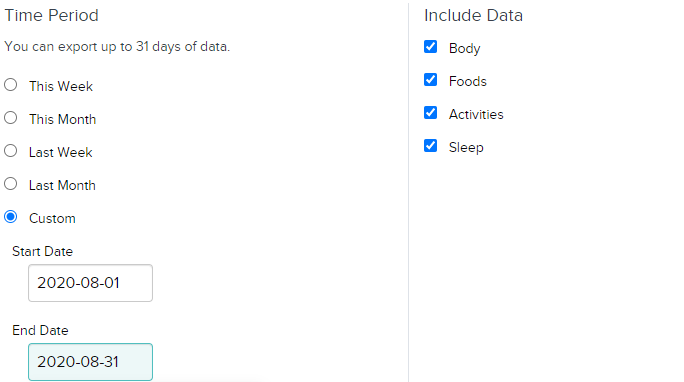

Second, after the month's data is downloaded, each category is stacked on top of each other in the same .csv file, with differing numbers of columns and data formats:  
  
  
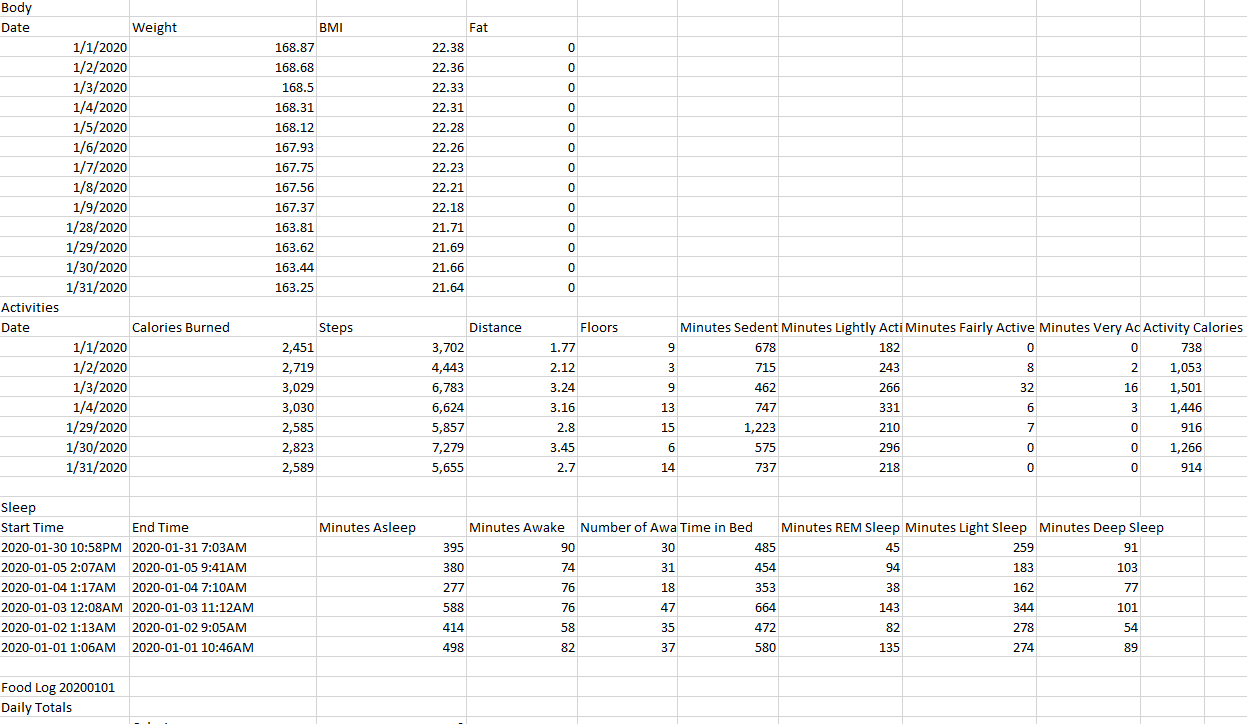

### Goals
* Import every .csv file from a single folder in a directory
* Separate the monthly data from each csv file by category
* Combine the category's data from each month into a single file  

    
      
      

# Start
The only libraries we need are numpy, pandas, datetime, and os.

In [ ]:
import numpy as np
import pandas as pd
import datetime
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

The first function we need will be called get_df, and will return a DataFrame object from the original .csv file that only contains the desired category (Sleep, Activities, etc.)

In [ ]:
def get_df(target_csv, category):
        #raw_df is a DataFrame that contains all the messy data in the original .csv file
    raw_df = pd.read_csv(target_csv,names = list(range(9)), skip_blank_lines = False)
    
        #"start" denotes the index where the data in the desired category begins
    start = int(np.where(raw_df[0] == category)[0] + 1)
    
        #"blank_separators" is a list of indices where the first column value is null, meaning the end of a category
    blank_separators = np.where(raw_df[0].isnull())[0]
        #"stop" finds the first value in this list comprehension of "blank_separators" that comes after the "start" index
    stop = [x for x in blank_separators if x > start][0] - 1
    return(pd.read_csv(target_csv, skiprows = start, nrows = stop-start))

# Combining data
The method combine() takes the desired category as an argument, walks through each month's .csv file in our directory, and finally returns just that category's data for every month combined into one DataFrame using our previously defined get_df() method.

In [ ]:
def combine(category):
    combined_df = pd.DataFrame()
    for filename in os.listdir(folder_path):
        combined_df = combined_df.append(get_df((folder_path +"/" + filename), category))
    return(combined_df)

Now we need to clean up the data types. As you can see, in our 'Activities' category, the variables Calories Burned, Steps, Activity calories, and Minutes Sedentary/Lightly active/Very active are stored as objects instead of integers. This will make it difficult if we want to analyze this data. We'd also like to change the 'Date' variable to a datetime object.

In [ ]:
folder_path = r'../input/d/jakebaisden/fitbit-exports'
combine('Activities').info()

In our 'Sleep' category, instad of the variable 'Date' we have 'Start Time' and 'End Time' variables stored as strings in the following format

In [ ]:
folder_path = r'../input/d/jakebaisden/fitbit-exports'
combine('Sleep').head()

To fix this, the clean_types() method below loops through each column with an "object" data type in a given DataFrame. If the column's values have commas anywhere, they'll be removed and the values will be converted to integers. When the method finds the 'Start Time' and 'End Time' columns, it will s

 so we'll need to drop those columns and make our own 'Date' column using the date from the 'End Time' variable

In [ ]:
def clean_types(df):
    for column in df:
        if df.dtypes[column] == 'object':
            try:
                df[column] = pd.to_numeric(df[column].str.replace(",", ""))
            except ValueError:
                df[column] = (df[column].str.split(n=1, expand = True))[0]
                df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d')
            except ValueError:
                df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d')
    return(df)


# Conclusion
Now we can finally merge both categories into a single dataframe called activities_vs_sleep, where the Date column refers to the day of the activity and the sleep data for that night. This can be exported into many different formats to be analyzed.